# Exploring Dandiset 001361: A flexible hippocampal population code for experience relative to reward

**⚠️ DISCLAIMER: This notebook was AI-generated and has not been fully verified. Exercise caution when interpreting code or results. ⚠️**

## Overview

This notebook explores Dandiset 001361, which contains 2-photon calcium imaging data from the hippocampal area CA1 of mice performing a virtual reality navigation task. The study aims to understand how hippocampal place cells encode spatial and reward-related information during learning.

Dandiset Link: [https://dandiarchive.org/dandiset/001361](https://dandiarchive.org/dandiset/001361)

In this notebook, we will:
1. Load the Dandiset and explore its metadata
2. Examine behavioral data from a virtual navigation task
3. Analyze neural activity and how it correlates with behavior
4. Investigate place cells and their spatial representation properties
5. Explore how the hippocampus encodes reward-relevant information

## Required Packages

This notebook requires the following packages:
- pynwb
- h5py
- remfile
- numpy
- pandas
- matplotlib
- seaborn

## Loading the Dandiset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import remfile
import pynwb
import seaborn as sns
sns.set_theme()

Let's connect to the DANDI archive and get information about Dandiset 001361:

In [2]:
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001361")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")

# List the assets in the Dandiset
assets = list(dandiset.get_assets())
print(f"\nFound {len(assets)} assets in the dataset")
print("\nFirst 5 assets:")
for asset in assets[:5]:
    print(f"- {asset.path}")

Dandiset name: A flexible hippocampal population code for experience relative to reward
Dandiset URL: https://dandiarchive.org/dandiset/001361/0.250406.0045

Found 152 assets in the dataset

First 5 assets:
- sub-m11/sub-m11_ses-05_behavior+ophys.nwb
- sub-m11/sub-m11_ses-04_behavior+ophys.nwb
- sub-m11/sub-m11_ses-07_behavior+ophys.nwb
- sub-m11/sub-m11_ses-06_behavior+ophys.nwb
- sub-m11/sub-m11_ses-08_behavior+ophys.nwb


## Exploring an NWB File

Let's load one of the NWB files from the Dandiset to explore its contents. We'll use a specific asset from the dataset.

We'll load `sub-m11/sub-m11_ses-03_behavior+ophys.nwb`, which contains both behavioral data and calcium imaging data from hippocampal CA1.

In [3]:
# Define the URL for the NWB file
nwb_asset_id = "d77ea78a-8978-461d-9d11-3c5cef860d82"  # Asset ID for sub-m11_ses-03_behavior+ophys.nwb
nwb_url = f"https://api.dandiarchive.org/api/assets/{nwb_asset_id}/download/"
print(f"Loading NWB file from URL: {nwb_url}")

# Load the NWB file
remote_file = remfile.File(nwb_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Print basic information about the dataset
print(f"Subject: {nwb.subject.subject_id}, Session: {nwb.session_id}")
print(f"Experiment: {nwb.identifier}")
print(f"Start time: {nwb.session_start_time}")
print(f"Location: {nwb.imaging_planes['ImagingPlane'].location}")
print(f"Indicator: {nwb.imaging_planes['ImagingPlane'].indicator}")
print(f"Imaging rate: {nwb.imaging_planes['ImagingPlane'].imaging_rate} Hz")

Loading NWB file from URL: https://api.dandiarchive.org/api/assets/d77ea78a-8978-461d-9d11-3c5cef860d82/download/


/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Subject: m11, Session: 03
Experiment: /data/InVivoDA/GCAMP11/23_02_2023/Env1_LocationB_to_A
Start time: 2023-02-23 00:00:00-08:00
Location: hippocampus, CA1
Indicator: GCaMP7f
Imaging rate: 15.5078125 Hz


## Analyzing Behavioral Data

The NWB file contains behavioral data from the virtual navigation task. Let's examine the position, speed, and reward-related information to understand what the mouse was doing during the experiment.

In [4]:
# Access behavioral data
behavior = nwb.processing["behavior"].data_interfaces["BehavioralTimeSeries"]

# Get the different behavioral variables
position = behavior.time_series["position"]
speed = behavior.time_series["speed"]
lick = behavior.time_series["lick"]
reward_zone = behavior.time_series["reward_zone"]
reward = behavior.time_series["Reward"]
trial_number = behavior.time_series["trial number"]
teleport = behavior.time_series["teleport"]

# Get data and timestamps
position_data = position.data[:]
position_timestamps = position.timestamps[:]
speed_data = speed.data[:]
lick_data = lick.data[:]
reward_zone_data = reward_zone.data[:]
trial_number_data = trial_number.data[:]
teleport_data = teleport.data[:]
reward_timestamps = reward.timestamps[:]

# Print some basic statistics
print(f"\nBehavioral data shape: {position_data.shape}")
print(f"Number of reward events: {len(reward_timestamps)}")
print(f"Total recording duration: {position_timestamps[-1] - position_timestamps[0]:.2f} seconds")


Behavioral data shape: (20684,)
Number of reward events: 69
Total recording duration: 1333.71 seconds


Let's visualize the behavioral data to understand the structure of the task. First, let's look at position over time and mark reward events:

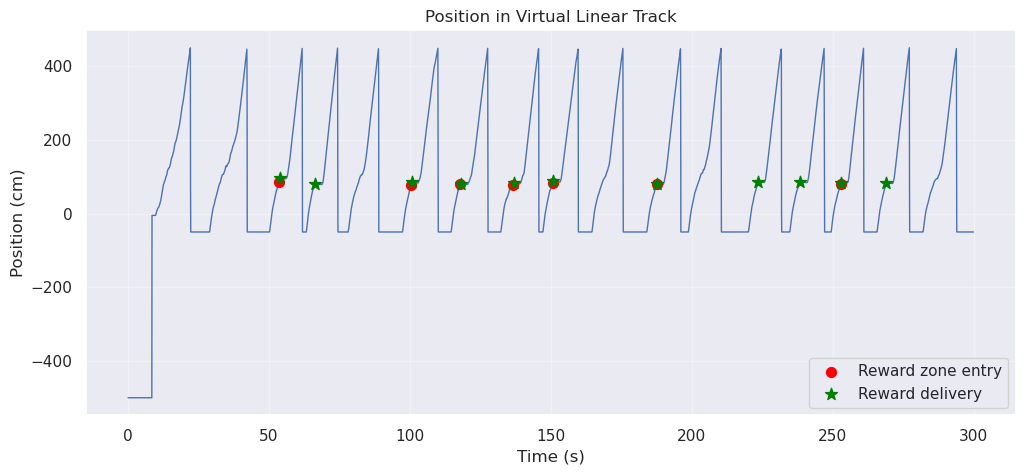

In [5]:
# For clarity, we'll just plot a subset of the data (first few minutes)
time_limit = 300  # First 5 minutes
idx = np.where(position_timestamps < position_timestamps[0] + time_limit)[0]

# Plot position over time
plt.figure(figsize=(12, 5))
plt.plot(position_timestamps[idx] - position_timestamps[0], position_data[idx], linewidth=1)

# Mark reward zone entries
reward_zone_entries = np.where(np.diff(reward_zone_data[idx].astype(int)) == 1)[0]
if len(reward_zone_entries) > 0:
    plt.scatter(position_timestamps[idx][reward_zone_entries] - position_timestamps[0], 
                position_data[idx][reward_zone_entries], 
                color='red', s=50, zorder=3, label='Reward zone entry')
# Mark rewards
reward_in_window = [r for r in reward_timestamps if r < position_timestamps[0] + time_limit]
if len(reward_in_window) > 0:
    reward_indices = [np.argmin(np.abs(position_timestamps - r)) for r in reward_in_window]
    plt.scatter([position_timestamps[i] - position_timestamps[0] for i in reward_indices], 
                [position_data[i] for i in reward_indices], 
                color='green', s=80, marker='*', zorder=4, label='Reward delivery')

plt.xlabel('Time (s)')
plt.ylabel('Position (cm)')
plt.title('Position in Virtual Linear Track')
plt.legend()
plt.grid(True, alpha=0.3)

This plot shows the mouse's position in the virtual linear track over time. We can see that the mouse completes several laps, with each lap consisting of a traversal from the start position to the reward zone (red dots), where rewards are delivered (green stars). After each reward, the mouse is teleported back to the start position to begin a new lap.

Let's also look at the distribution of positions and where rewards occur:

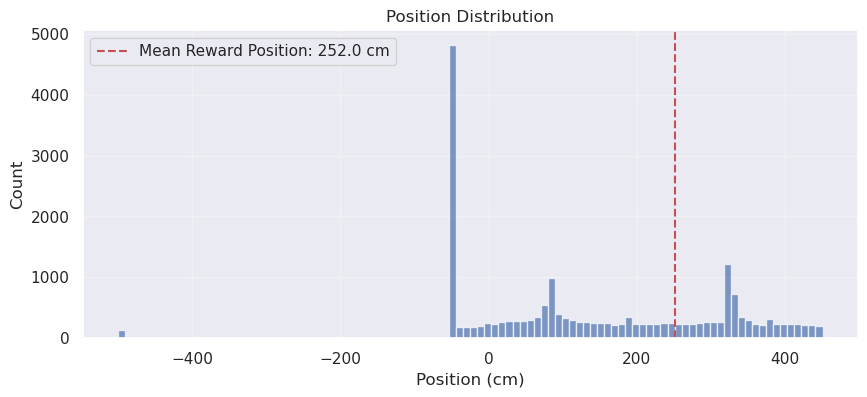

In [6]:
# Plot position distribution and reward zone
plt.figure(figsize=(10, 4))
plt.hist(position_data, bins=100, alpha=0.7)

# Mark where rewards occur
reward_positions = []
for r_time in reward_timestamps:
    idx = np.argmin(np.abs(position_timestamps - r_time))
    reward_positions.append(position_data[idx])
    
plt.axvline(np.mean(reward_positions), color='r', linestyle='--', 
            label=f'Mean Reward Position: {np.mean(reward_positions):.1f} cm')
plt.xlabel('Position (cm)')
plt.ylabel('Count')
plt.title('Position Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

This histogram shows where the mouse spends most of its time in the virtual track. The peaks in the distribution represent locations where the mouse tends to slow down or pause. The red dashed line marks the average position where rewards are delivered.

Now let's examine the licking behavior relative to position to see if the mouse anticipates the reward:

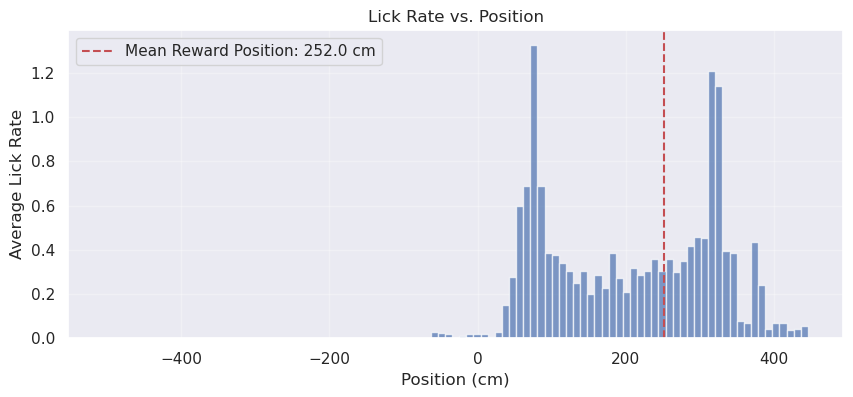

In [7]:
# Bin positions and get average lick rate in each bin
bins = np.linspace(np.min(position_data), np.max(position_data), 100)
bin_indices = np.digitize(position_data, bins)
bin_lick_rates = []

for i in range(1, len(bins)):
    indices = np.where(bin_indices == i)[0]
    if len(indices) > 0:
        bin_lick_rates.append(np.mean(lick_data[indices]))
    else:
        bin_lick_rates.append(0)

plt.figure(figsize=(10, 4))
plt.bar(bins[:-1], bin_lick_rates, width=np.diff(bins)[0], alpha=0.7)
plt.axvline(np.mean(reward_positions), color='r', linestyle='--', 
            label=f'Mean Reward Position: {np.mean(reward_positions):.1f} cm')
plt.xlabel('Position (cm)')
plt.ylabel('Average Lick Rate')
plt.title('Lick Rate vs. Position')
plt.legend()
plt.grid(True, alpha=0.3)

This plot shows the licking behavior as a function of position in the track. We can see that the mouse's licking increases as it approaches the reward zone, indicating that it has learned to anticipate the reward at specific locations. The red dashed line shows the average position where rewards are delivered.

Let's also look at the structure of individual trials by plotting all trials aligned:

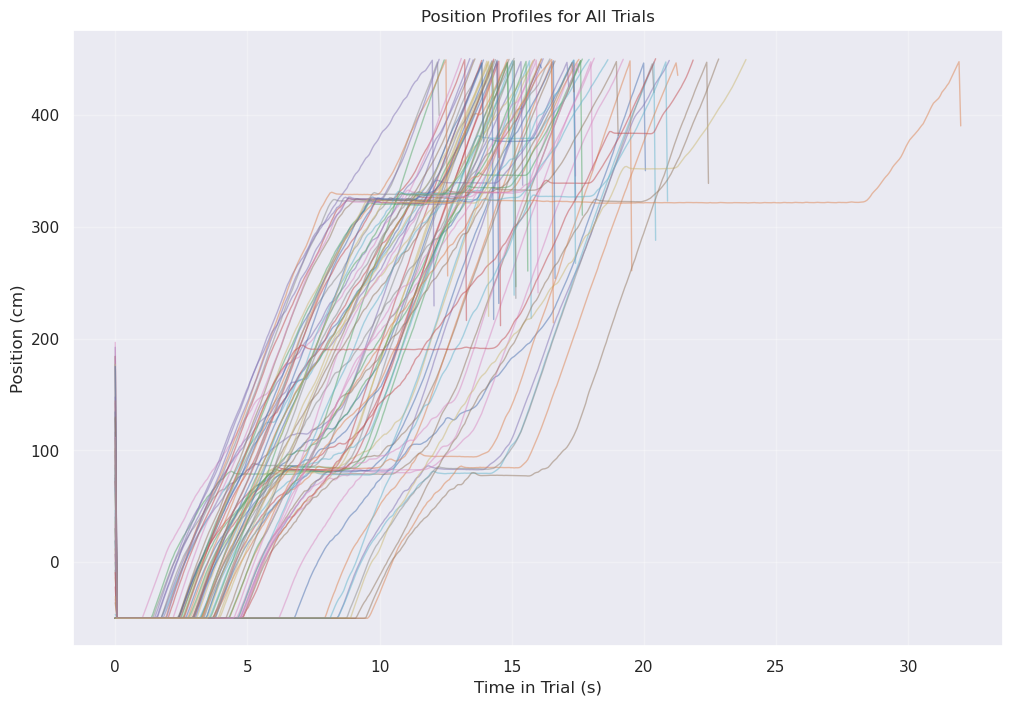

In [8]:
# Get all trials and their durations
trial_ids = np.unique(trial_number_data)

# For each trial, extract position vs time
plt.figure(figsize=(12, 8))
for trial in trial_ids:
    if trial <= 0:  # Skip zero or negative trials which might be pre-task
        continue
    trial_indices = np.where(trial_number_data == trial)[0]
    if len(trial_indices) == 0:
        continue
    trial_time = position_timestamps[trial_indices] - position_timestamps[trial_indices[0]]
    trial_pos = position_data[trial_indices]
    plt.plot(trial_time, trial_pos, alpha=0.5, linewidth=1)

plt.xlabel('Time in Trial (s)')
plt.ylabel('Position (cm)')
plt.title(f'Position Profiles for All Trials')
plt.grid(True, alpha=0.3)

This plot shows the position trajectories for all trials, aligned to the start of each trial. We can see that there is a consistent pattern across trials, with the mouse starting at a low position value, running forward (increasing position), and then being teleported back to the start position at the end of the trial.

## Exploring Neural Activity

Now let's examine the neural activity data from hippocampal CA1. The dataset contains calcium imaging data from multiple neurons, which we can analyze to understand how these cells encode spatial information.

In [9]:
# Get neural activity data
fluorescence = nwb.processing["ophys"].data_interfaces["Fluorescence"].roi_response_series["plane0"]
deconvolved = nwb.processing["ophys"].data_interfaces["Deconvolved"].roi_response_series["plane0"]

# Get cell information
cell_table = nwb.processing["ophys"].data_interfaces["ImageSegmentation"].plane_segmentations["PlaneSegmentation"]
cell_df = cell_table.to_dataframe()

print("Neural data shape:", fluorescence.data.shape)
print("Number of ROIs:", len(cell_df))

# Check how many cells were classified as actual cells vs. artifacts
if 'iscell' in cell_df.columns:
    # The iscell column contains arrays with classification and probability
    iscell_values = np.array([row[0] if hasattr(row, '__len__') else row for row in cell_df['iscell']])
    print(f"Number of classified cells: {np.sum(iscell_values > 0)}")

Neural data shape: (19818, 349)
Number of ROIs: 349
Number of classified cells: 155


### Visualizing Neural Activity with Behavior

Let's visualize the neural activity of a few example cells along with the animal's position to see if there are relationships between neural activity and behavior.

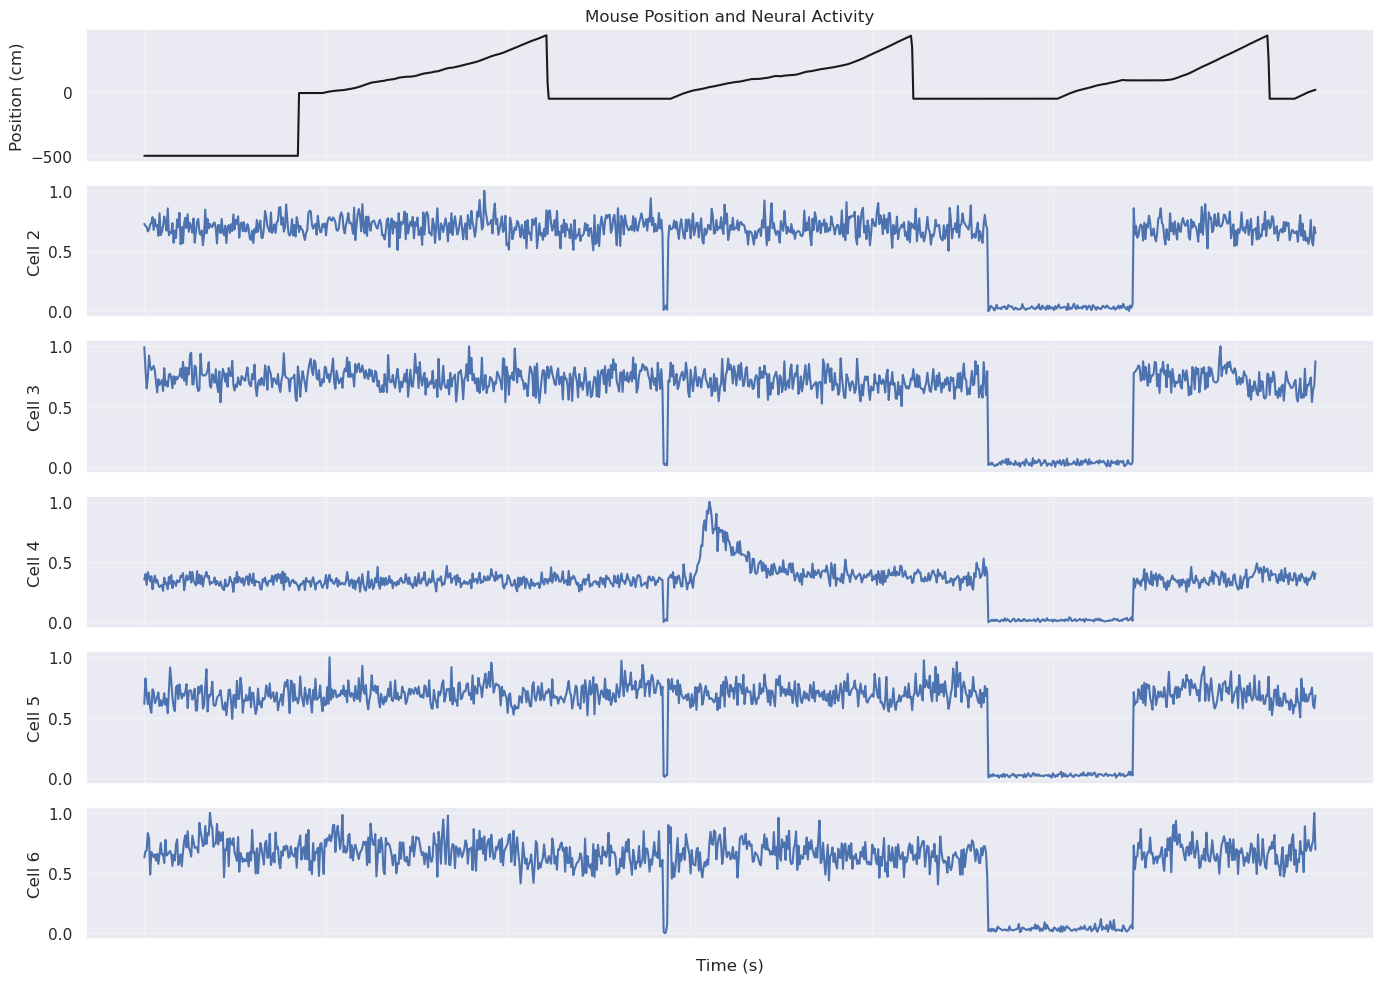

In [10]:
# Get a subset of the data for visualization (first 1000 timepoints)
time_limit = 1000
f_data = fluorescence.data[:time_limit, :]  # Time x Cells
f_timestamps = np.arange(time_limit) / fluorescence.rate + fluorescence.starting_time

# Get corresponding position data
pos_indices = []
for ts in f_timestamps:
    idx = np.argmin(np.abs(position_timestamps - ts))
    pos_indices.append(idx)

matched_positions = position_data[pos_indices]

# Select a few example cells
n_examples = 5
if 'iscell' in cell_df.columns:
    # Use cells classified as real cells
    example_cells = np.where(iscell_values > 0)[0][:n_examples]
else:
    # Just use the first few cells
    example_cells = np.arange(n_examples)

# Plot the activity of example cells over time along with position
plt.figure(figsize=(14, 10))
ax1 = plt.subplot(n_examples+1, 1, 1)
ax1.plot(f_timestamps, matched_positions, 'k')
ax1.set_ylabel('Position (cm)')
ax1.set_title('Mouse Position and Neural Activity')
ax1.set_xticklabels([])
ax1.grid(True, alpha=0.3)

for i, cell_idx in enumerate(example_cells):
    ax = plt.subplot(n_examples+1, 1, i+2, sharex=ax1)
    # Normalize the fluorescence data for better visualization
    cell_data = f_data[:, cell_idx]
    if np.max(cell_data) > np.min(cell_data):
        norm_f = (cell_data - np.min(cell_data)) / (np.max(cell_data) - np.min(cell_data))
    else:
        norm_f = np.zeros_like(cell_data)
    ax.plot(f_timestamps, norm_f)
    ax.set_ylabel(f'Cell {cell_idx}')
    ax.grid(True, alpha=0.3)
    if i < n_examples - 1:
        ax.set_xticklabels([])
    
ax.set_xlabel('Time (s)')
plt.tight_layout()

The plot above shows the mouse's position (top) along with the neural activity of several example cells. We can observe that some cells show increased activity at specific positions in the track, which is characteristic of place cells in the hippocampus.

### Analyzing Place Cells

Let's identify place cells by creating a spatial tuning curve for each cell, showing how their activity varies with position in the track.

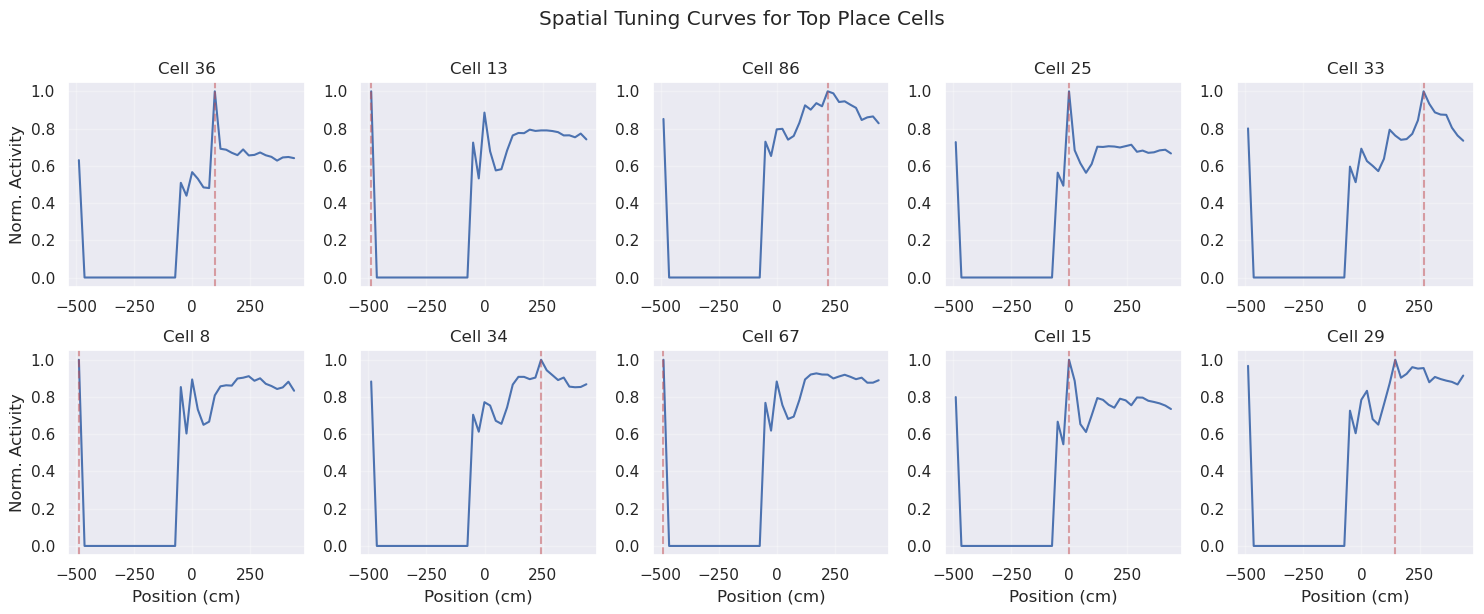

In [11]:
# Create position bins
pos_bins = np.linspace(np.min(matched_positions), np.max(matched_positions), 40)
bin_centers = (pos_bins[:-1] + pos_bins[1:]) / 2
bin_indices = np.digitize(matched_positions, pos_bins) - 1
bin_indices[bin_indices >= len(pos_bins)-1] = len(pos_bins) - 2  # Fix any out-of-bound indices

# Create spatial tuning curves for all cells
spatial_tuning = np.zeros((len(bin_centers), f_data.shape[1]))
for i in range(len(bin_centers)):
    in_bin = bin_indices == i
    if np.sum(in_bin) > 0:  # Make sure there are timepoints in this bin
        spatial_tuning[i, :] = np.mean(f_data[in_bin, :], axis=0)

# Find cells with strong spatial tuning
# Compute the peak-to-baseline ratio for each cell
baseline = np.percentile(spatial_tuning, 10, axis=0)
peak = np.max(spatial_tuning, axis=0)
peak_to_baseline = peak / (baseline + 1e-6)  # Avoid division by zero

# Select top place cells
n_place_cells = 20
place_cell_indices = np.argsort(peak_to_baseline)[::-1][:n_place_cells]
if 'iscell' in cell_df.columns:
    # Ensure they're classified as cells
    place_cell_indices = [idx for idx in place_cell_indices if iscell_values[idx] > 0][:10]
else:
    place_cell_indices = place_cell_indices[:10]  # Just show the top 10

# Plot spatial tuning curves for top place cells
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, cell_idx in enumerate(place_cell_indices):
    if i >= len(axes):  # In case we have fewer than 10 place cells
        break
        
    # Normalize for better visualization
    tuning = spatial_tuning[:, cell_idx]
    if np.max(tuning) > np.min(tuning):
        norm_tuning = (tuning - np.min(tuning)) / (np.max(tuning) - np.min(tuning))
    else:
        norm_tuning = np.zeros_like(tuning)
    
    axes[i].plot(bin_centers, norm_tuning)
    axes[i].set_title(f'Cell {cell_idx}')
    axes[i].grid(True, alpha=0.3)
    
    # Show peak position with a vertical line
    peak_pos = bin_centers[np.argmax(norm_tuning)]
    axes[i].axvline(x=peak_pos, color='r', linestyle='--', alpha=0.5)
    
    if i % 5 == 0:  # Add y-axis label for leftmost plots
        axes[i].set_ylabel('Norm. Activity')
    
    if i >= 5:  # Add x-axis label for bottom plots
        axes[i].set_xlabel('Position (cm)')

plt.tight_layout()
plt.suptitle('Spatial Tuning Curves for Top Place Cells', y=1.02)
plt.subplots_adjust(top=0.9)

The plots above show the spatial tuning curves for the top 10 place cells, sorted by their peak-to-baseline ratio. Each plot shows how a cell's activity varies with the mouse's position in the track. The red dashed line indicates the position where the cell's activity peaks.

We can see that different cells have preferred firing locations at different positions in the track, collectively forming a representation of the entire environment.

### Population Analysis of Place Cells

Let's visualize the entire population of neurons to see how they collectively encode spatial information. We'll create a heatmap showing the spatial tuning of all neurons, sorted by their preferred positions.

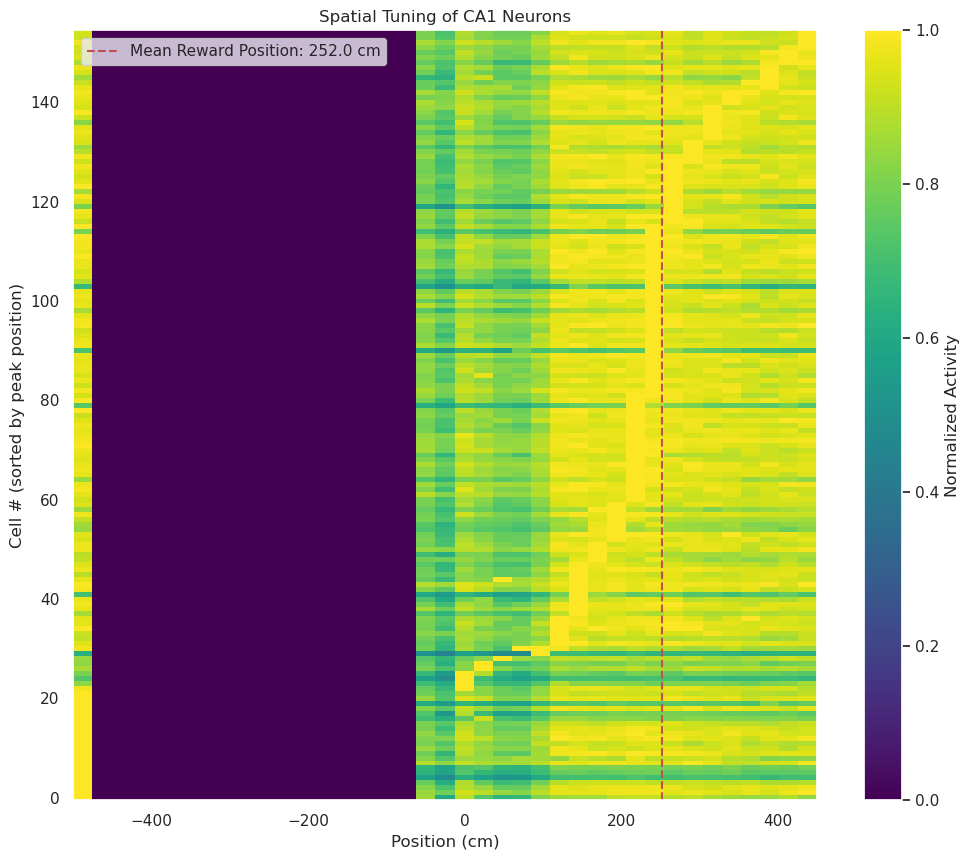

In [12]:
# Sort cells by position of peak activity
peak_pos = np.argmax(spatial_tuning, axis=0)
sort_idx = np.argsort(peak_pos)

# Only use cells classified as cells if available
if 'iscell' in cell_df.columns:
    cell_sort_idx = [idx for idx in sort_idx if iscell_values[idx] > 0]
else:
    cell_sort_idx = sort_idx

# Normalize each cell's spatial tuning curve
norm_tuning = np.zeros_like(spatial_tuning)
for i in range(spatial_tuning.shape[1]):
    tuning = spatial_tuning[:, i]
    if np.max(tuning) > np.min(tuning):
        norm_tuning[:, i] = (tuning - np.min(tuning)) / (np.max(tuning) - np.min(tuning))

# Create heatmap with cells sorted by peak position
plt.figure(figsize=(12, 10))
plt.pcolormesh(bin_centers, np.arange(len(cell_sort_idx)), 
               norm_tuning[:, cell_sort_idx].T, cmap='viridis', shading='auto')
plt.colorbar(label='Normalized Activity')
plt.ylabel('Cell # (sorted by peak position)')
plt.xlabel('Position (cm)')
plt.title('Spatial Tuning of CA1 Neurons')

# Mark the mean reward position with a vertical line
reward_position = np.mean(reward_positions)
plt.axvline(x=reward_position, color='r', linestyle='--', 
           label=f'Mean Reward Position: {reward_position:.1f} cm')
plt.legend()
plt.grid(False)

This heatmap shows the spatial tuning of all CA1 neurons, with each row representing a different neuron and each column representing a position in the track. The neurons are sorted by the position of their peak activity, creating a diagonal pattern from bottom left to top right.

The red dashed line marks the mean reward position. We can observe that many neurons have activity peaks around this position, suggesting an over-representation of the reward zone in the hippocampal map. This is consistent with the study's finding that hippocampal neurons encode experience relative to reward.

## Summary

In this notebook, we explored a dataset from Dandiset 001361, which contains 2-photon imaging data from hippocampal area CA1 during virtual reality navigation in mice.

Key findings:

1. The experimental task involved mice navigating a virtual linear track to reach a reward zone.

2. Behavioral analysis showed that mice learned to anticipate rewards, as evidenced by increased licking behavior as they approached the reward zone.

3. Hippocampal CA1 neurons exhibited place cell properties, with each neuron having a preferred firing location in the virtual environment.

4. Population analysis revealed that the reward zone appeared to be over-represented in the hippocampal map, consistent with the study's finding that hippocampal activity flexibly encodes experience relative to reward.

These findings support the concept that the hippocampus not only represents spatial information but also integrates behaviorally relevant experiences, particularly those related to rewards.

## Future Directions

Future analyses could explore:

1. How the hippocampal representation changes over learning as the animal becomes more familiar with the task.

2. Whether there are transitions in the neural code when the reward location changes.

3. The relationship between neural activity and specific behaviors like stopping, accelerating, or licking.

4. More detailed analyses of the population dynamics, such as how ensembles of neurons coordinate their activity during navigation.